## DESCRIPCION DEL PROYECTO

La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con clientes basada en datos analíticos. Uno de los problemas más comunes que enfrentan los gimnasios y otros servicios es la pérdida de clientes. Vamos a descubrir si un/a cliente ya no está en el gimnasio. Podemos calcular la pérdida en función de las personas que se deshacen de sus cuentas o no renuevan sus contratos. Sin embargo, a veces no es obvio que un/a cliente se haya ido

Con el fin de combatir la cancelación, Model Fitness ha digitalizado varios de sus perfiles de clientes. La tarea consiste en analizarlos y elaborar una estrategia de retención de clientes.

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans

import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#vamos a leer los datos
gym = pd.read_csv('/datasets/gym_churn_us.csv')

In [3]:
#Mostramos su tamaño y las primeras 5 filas
print(gym.shape)
print(gym.head(5))

(4000, 14)
   gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_m

El DataFrame tiene un tamaño mediano, tiene 4000 observaciones y 14 campos. La variable objetivo es la columna 'Churn' ya que nos indica si un cliente ha dejado el gimnasio (1) o no (0). Contamos con 13 características.

###  Análisis exploratorio de datos (EDA)

In [4]:
#Vamos a verificar si tenemos datos ausentes y el tipo de datos de cada columna
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
print(gym.isna().sum())

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64


No tenemos datos ausentes y los tipo de datos de cada columna son correctos.

In [6]:
#Vamos a verificar los datos de nuestra variable objetivo 'churn' que solo contenga ceros y unos.
category_churn = gym['Churn'].value_counts()
print(category_churn)

0    2939
1    1061
Name: Churn, dtype: int64


1.0 Vamos a estudiar los valores promedio y la desviación estándar (utilizando el método describe()).

In [7]:
print(gym.describe())

            gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.00

1. En 'gender': 0 = Femenino, 1 = Masculino.
- mean = 0.51: Hay una ligera mayoría de hombres

2. En 'Near_Location': 1 = Cerca, 0 = Lejos.
- mean = 0.85: La mayoria de los clientes viven cerca al gym.

3. En 'Age':
 -mean = 29.18. La mayoria de los clientes estan cercanos a los 30 años.

2.0 Observaremos los valores medios de las características en dos grupos: para las personas que se fueron (cancelación) y para las que se quedaron (utilizaremos el método groupby()).

In [8]:
#Calcularemos los valores medios para cada grupo de 'Churn'
grouped_means = gym.groupby('Churn').mean()
print(grouped_means)

         gender  Near_Location   Partner  Promo_friends     Phone  \
Churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       Contract_period  Group_visits        Age  Avg_additional_charges_total  \
Churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
Churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       Avg_class_frequency_current_month  
Churn                                     
0                               2.0

4. Con respecto a la variable objetivo 'Churn': cliente dejó el gimnasio = 1,  No lo dejó = 0
- Gender: Tenemos igualdad con respecto al género los que se quedaron y los que dejaron el gym.
- Near_Location: El 87.3% de los clientes que se quedaron viven cerca del gym. El 76.8% de los clientes que se fueron vivian cerca del gym.
- Contract_period: 5.75 meses promedio de contrato los clientes que se quedaron. 1.73 meses promedio de contrato los clientes que se fueron.
- Age: Un promedio de 29.98 años tienen los clientes que se quedaron. Un promedio de 27 años tienen los clientes que se fueron.

En conclusion parece influir la retención de clientes si viven cerca al gym y la duración de tiempo de contrato que hagan. Tambien influye la edad, mientras mas cerca estén a los 30 años, se quedarán. Puede ser que la estrategia de retención tenga que ver con enfocarse ofrecer incentivos para realizar contratos largos y adaptarse a los servicios más requeridos para los clientes jóvenes.

1.3 Trazaremos histogramas de barras y distribuciones de características para aquellas personas que se fueron (cancelación) y para las que se quedaron.

In [9]:
#Trazamos histogramas de barras y distribuciones de las características

#Excluímos la columna 'Churn'
features = gym.columns[:-1]

  0%|          | 0/13 [00:00<?, ?it/s]

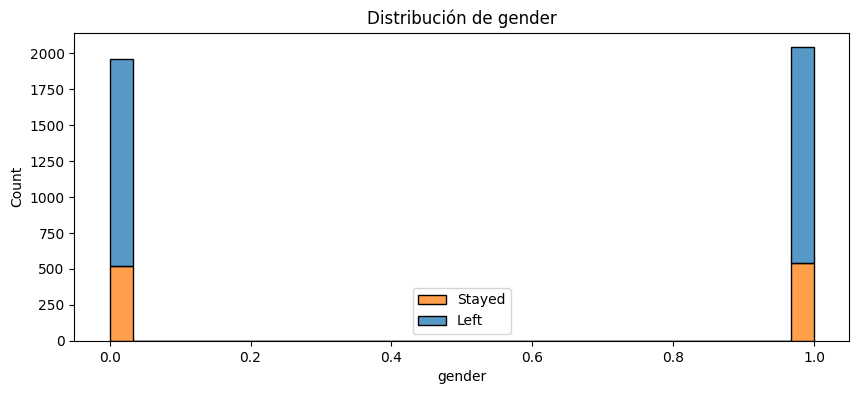

  8%|▊         | 1/13 [00:00<00:03,  3.90it/s]

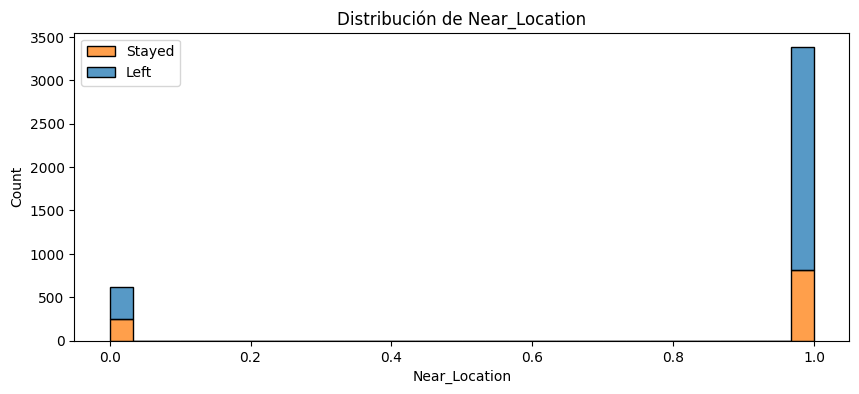

 15%|█▌        | 2/13 [00:00<00:02,  3.69it/s]

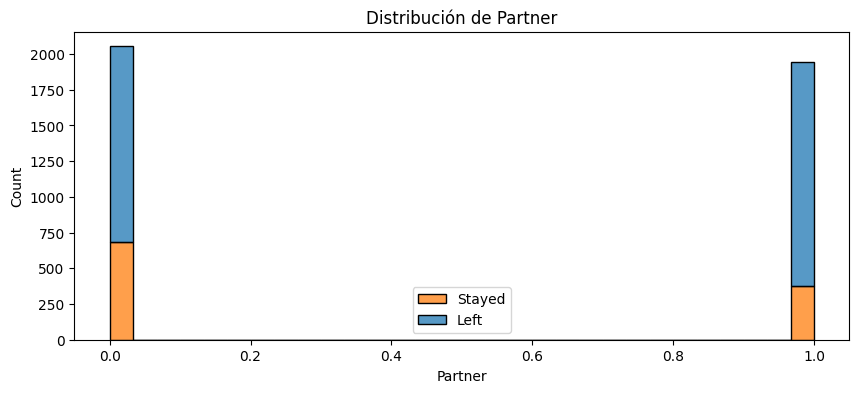

 23%|██▎       | 3/13 [00:00<00:02,  4.09it/s]

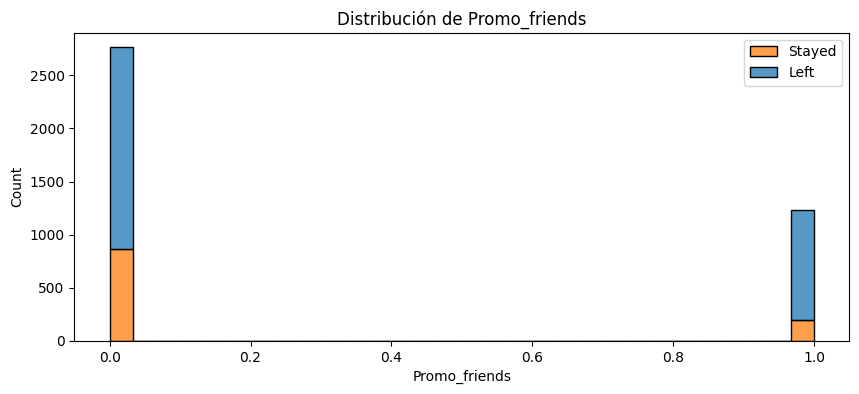

 31%|███       | 4/13 [00:00<00:02,  4.37it/s]

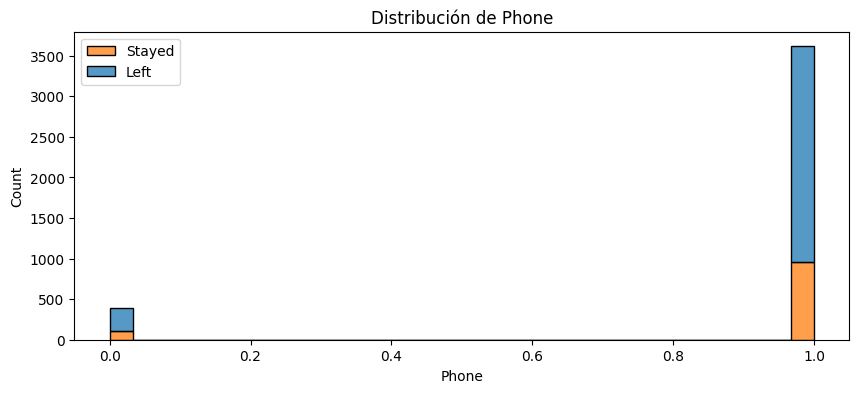

 38%|███▊      | 5/13 [00:01<00:01,  4.54it/s]

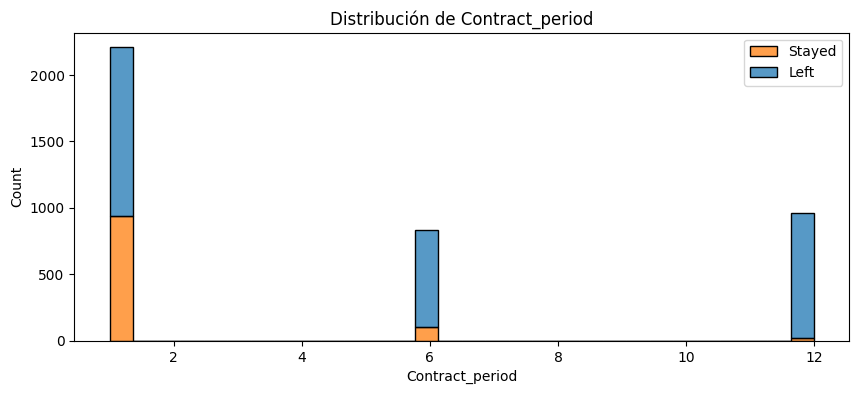

 46%|████▌     | 6/13 [00:01<00:01,  4.72it/s]

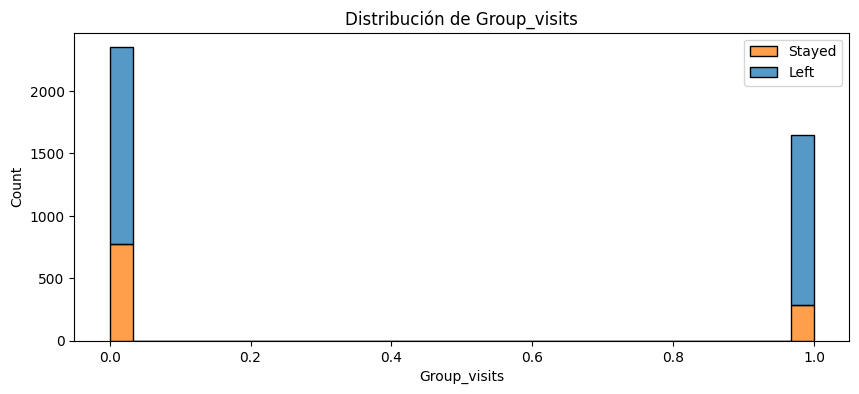

 54%|█████▍    | 7/13 [00:01<00:01,  4.81it/s]

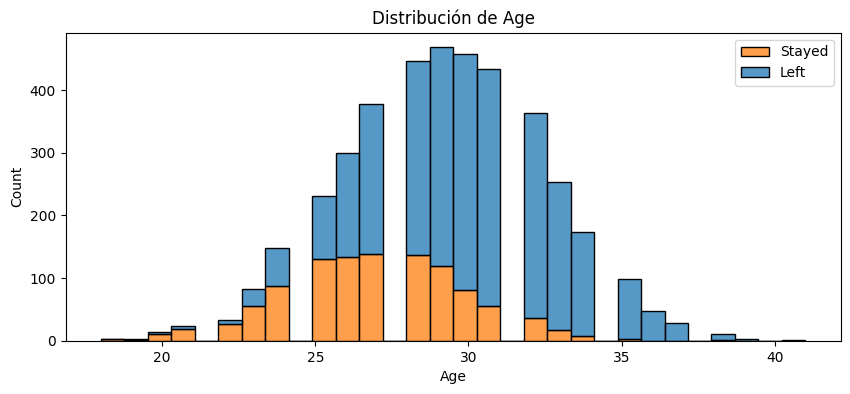

 62%|██████▏   | 8/13 [00:01<00:01,  4.33it/s]

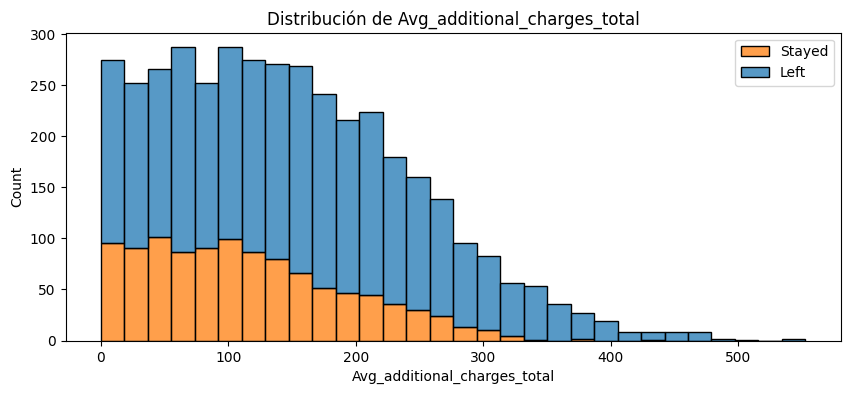

 69%|██████▉   | 9/13 [00:02<00:00,  4.49it/s]

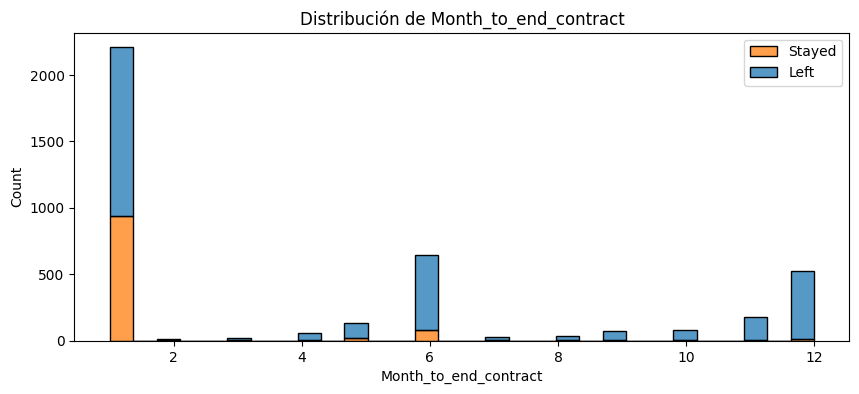

 77%|███████▋  | 10/13 [00:02<00:00,  4.67it/s]

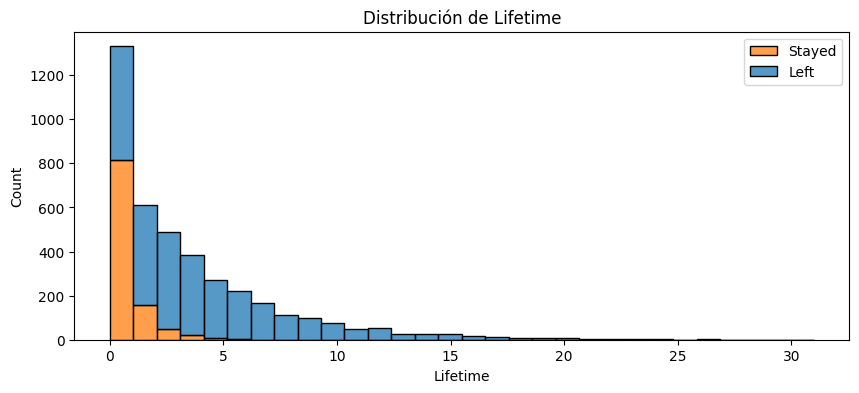

 85%|████████▍ | 11/13 [00:02<00:00,  4.69it/s]

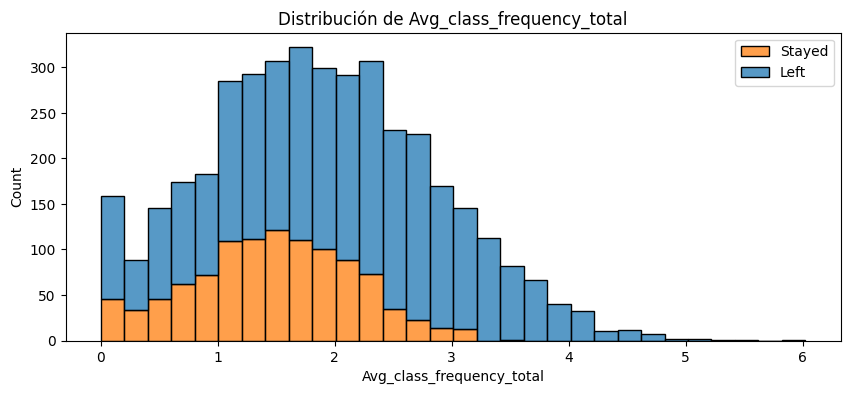

 92%|█████████▏| 12/13 [00:02<00:00,  4.71it/s]

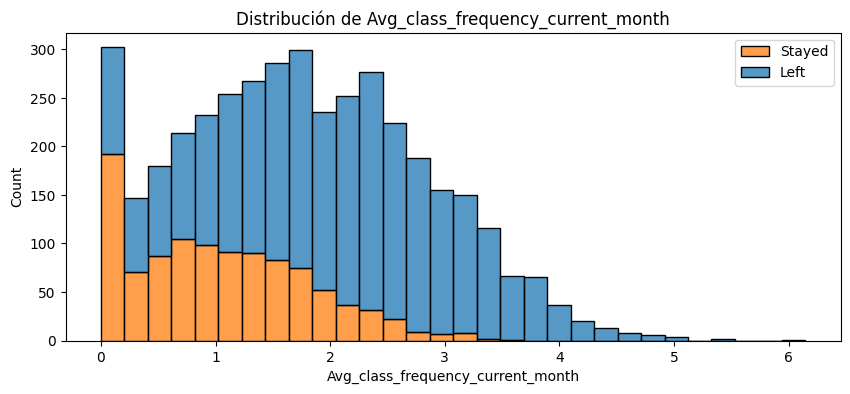

100%|██████████| 13/13 [00:02<00:00,  4.41it/s]


In [10]:
#Ejecutamos el bucle para los diagramas con tqmd que nos permite mostrar barras en progreso mientras
#se va ejecutando el bucle y nos ayuda a trazar múltiples gráficos
for feature in tqdm(features):
    plt.figure(figsize=(10, 4))
    sns.histplot(data=gym, x=feature, hue='Churn', multiple='stack', bins=30)
    plt.title('Distribución de ' + feature)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(['Stayed', 'Left'])
    plt.show()

Los histogramas muestran la distribución de cada característica para ambos grupos(los clientes que se queda y los que se van), proporcionando una visualización de cómo varían cada una de las características entre los que se quedaron y los que se fueron.

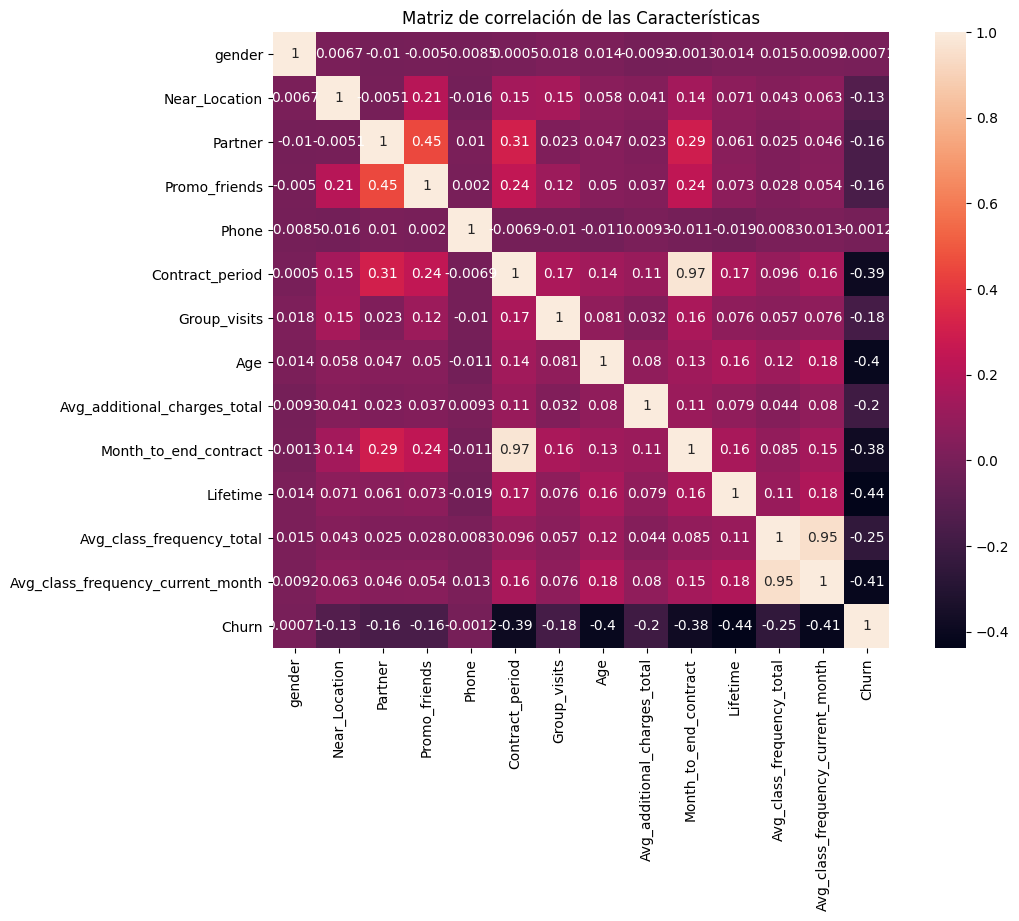

In [11]:
#Crearemos una matriz de correlacion
cm = gym.corr()

plt.figure(figsize=(12, 8))

#Usamos seaborn para trazar un mapa de calor de la matriz de correlación
sns.heatmap(cm, annot=True, square=True)
plt.title('Matriz de correlación de las Características')
plt.show()

No observamos ningún sesgo o valor atípico, cada valor en los recuadros representa la afinidad y relación en cuanto a las características de cada columna.

### Construimos un modelo para predecir la cancelación de usuarios

Creamos un modelo de clasificación binaria para clientes donde la característica objetivo es la marcha del usuario o la usuaria el mes siguiente.

1. Entrenamos el modelo en el set de entrenamiento con dos métodos:
- regresión logística
- bosque aleatorio.

In [12]:
#Dividimos los datos en características (la matriz X) y la variable objetivo(y)
X = gym.drop('Churn', axis = 1)
y = gym['Churn']

In [13]:
#Dividimos los datos en entrenamiento y prueba
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
#Creamos un objeto StandarScaler y lo aplicamos al set de entrenamiento
scaler = StandardScaler()
#Entrenamos el scaler y transformamos la matriz del set de entrenamiento
X_train_st = scaler.fit_transform(X_train)

#Transformamos el conjunto de validación
X_val_st = scaler.transform(X_val)

In [15]:
#Definimos los algoritmos modelo ()
models = [LogisticRegression(random_state=0), RandomForestClassifier(random_state=0)]

2. Evaluamos la exactitud, precisión y recall para ambos modelos utilizando los datos de validación. Los utilizamos para comparar los modelos. ¿Qué modelo dio mejores resultados?

In [16]:
for model in models:
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_val_st)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    print(model.__class__.__name__ + " - Accuracy: ", accuracy)
    print(model.__class__.__name__ + " - Precision: ", precision)
    print(model.__class__.__name__ + " - Recall: ", recall)

LogisticRegression - Accuracy:  0.9225
LogisticRegression - Precision:  0.8541666666666666
LogisticRegression - Recall:  0.8282828282828283
RandomForestClassifier - Accuracy:  0.915
RandomForestClassifier - Precision:  0.8385416666666666
RandomForestClassifier - Recall:  0.8131313131313131


Exactitud: 

- Hemos medio la proporción de predicciones correctas sobre el total de predicciones. Podemos ver que la regresión logistica (LogisticRegression = 0.9225 = 92.25%) tiene una exactitud ligeramente superior a la del bosque aleatorio (RandomForestClassifier = 0.915 = 91.5%), quiere decir que la regresión logística es un poco mejor.


Precisión: 
+ LogisticRegression - Precision:  0.854 = 85.4%
+ RandomForestClassifier - Precision:  0.838 = 83.8%

Estos datos nos proporcionan de verdaderos positivos del total de predicciones positivas. La regresión logística tiene una precisión ligeramente superior al bosque aleatorio, quiere decir que la regresión logística es un poco mejor en minimizar los falsos positivos.


Recall: 
+ LogisticRegression - Recall:  0.828 = 82.8%
+ RandomForestClassifier - Recall:  0.813 = 81.3%

Recall mide la proporción de verdaderos positivos sobre el real de casos reales positivos.
Aquí también podemos ver que la regresión logística tiene un recall ligeramente superior al bosque aleatorio. Esto nos indica que la regresión logística es un poco mejor en identificar a los clientes que realmente se van.

### Crear clústeres de usuarios/as

Dejaremos de lado la columna con datos sobre la cancelación e identificamos los clústeres de objetos (usuarios/as):

- Estandarizaremos los datos.

In [17]:
#Estandarizamos los datos.
scaler = StandardScaler()
x_sc = scaler.fit_transform(gym.drop(columns = ['Churn']))

In [18]:
#Transformamos nuestra tabla de origen:
print(x_sc[:10])

[[ 0.97970588  0.42788074  1.02686062  1.49716101 -3.05985201  0.28989014
   1.19403206 -0.0565538  -1.37753121  0.16160501 -0.19332863 -1.91191971
  -1.67847198]
 [-1.0207145   0.42788074 -0.973842   -0.66793083  0.32681319  1.60882159
   1.19403206  0.55732732 -0.35021325  1.83194105  0.87368001  0.04517569
   0.1360137 ]
 [-1.0207145   0.42788074  1.02686062 -0.66793083  0.32681319 -0.8092194
  -0.83749845 -0.36349436 -0.1815923  -0.79287273 -0.46008079 -0.02049263
  -0.02901851]
 [-1.0207145   0.42788074  1.02686062  1.49716101  0.32681319  1.60882159
   1.19403206  1.17120844 -0.87472237  1.83194105 -0.46008079  1.36465509
   1.51045005]
 [ 0.97970588  0.42788074  1.02686062  1.49716101  0.32681319 -0.8092194
  -0.83749845 -0.97737548  0.5336998  -0.79287273 -0.19332863 -0.78707638
  -0.61454183]
 [ 0.97970588  0.42788074 -0.973842   -0.66793083  0.32681319 -0.8092194
   1.19403206  1.478149    3.15330097 -0.79287273 -0.19332863  0.76580519
   0.82634551]
 [ 0.97970588  0.42788074

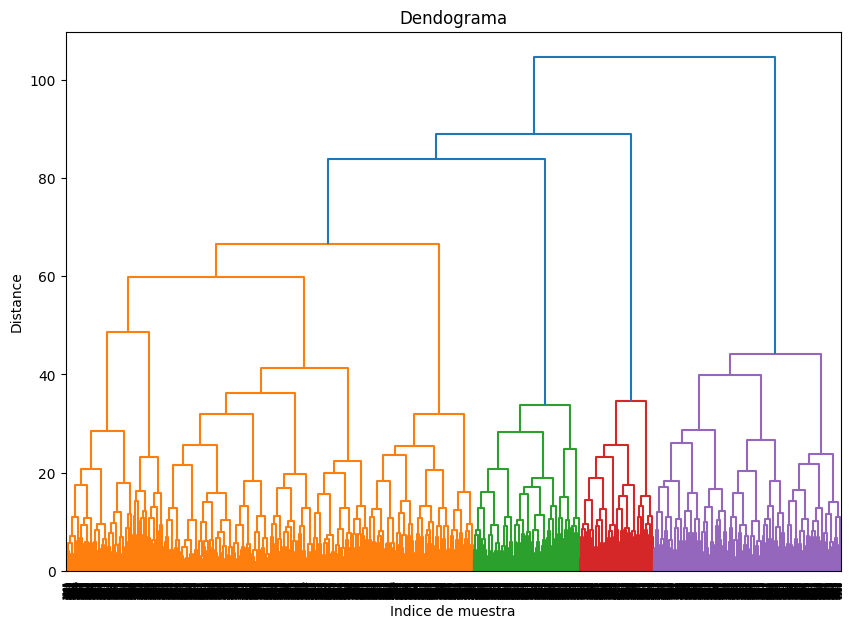

In [19]:
# 1. Utilizamos la función linkage() y el método 'ward' para crear una matriz de distancias 
# 2. Basada en la matriz de características estandarizada y trazamos un dendrograma. 
linked = linkage(x_sc, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendograma')
plt.xlabel('Indice de muestra')
plt.ylabel('Distance')
plt.show()

In [20]:
#Entrenaremos el modelo de clustering con el algortimo K-means y predice los clústeres de clientes.

km = KMeans(n_clusters = 5)
labels = km.fit_predict(x_sc)

In [21]:
#Asignamos clusters al DataFrame
gym['Cluster_km'] = labels

#Obtenemos estadísticas de los valores medios de las características por clúster
gym.groupby(['Cluster_km']).mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
Cluster_km,,,,,,,,,,,,,,
0,0.483974,1.000000,0.353365,0.239583,1.0,1.963141,0.341346,28.179487,131.393110,1.870192,2.406250,1.237070,1.001342,0.516026
1,0.500493,0.960591,0.782266,0.573399,1.0,10.882759,0.541872,29.988177,161.115188,9.944828,4.733005,1.995889,1.988918,0.027586
2,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839
3,0.497041,0.000000,0.461538,0.078895,1.0,2.378698,0.218935,28.479290,135.631940,2.224852,2.812623,1.662253,1.480228,0.441815
4,0.562796,0.977488,0.350711,0.231043,1.0,2.581754,0.470379,30.074645,160.941520,2.382701,4.911137,2.829267,2.824471,0.073460


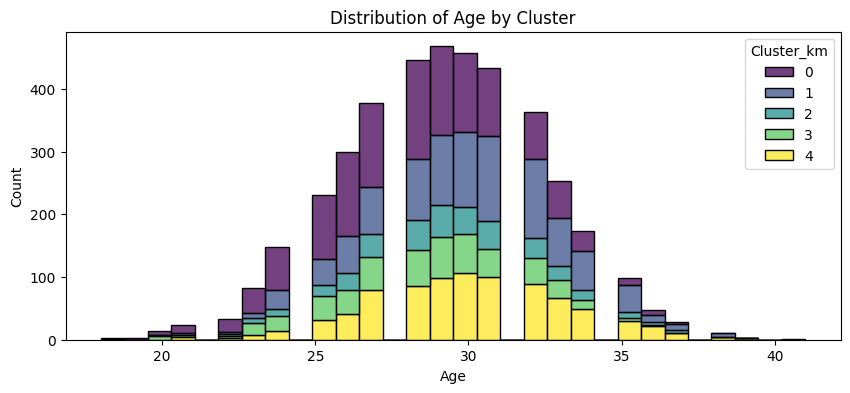

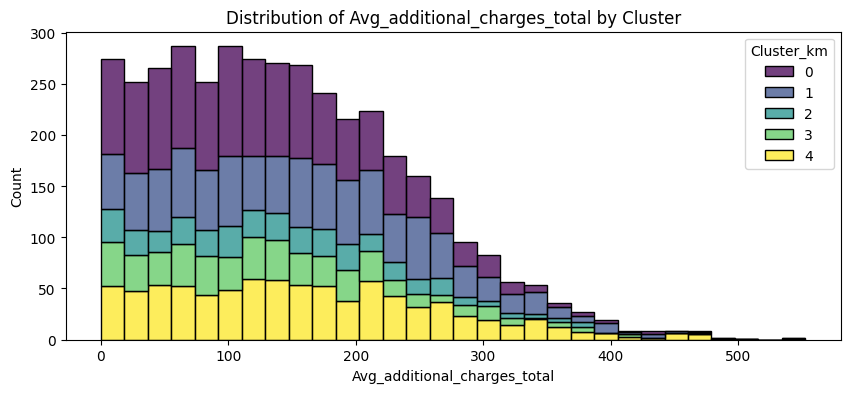

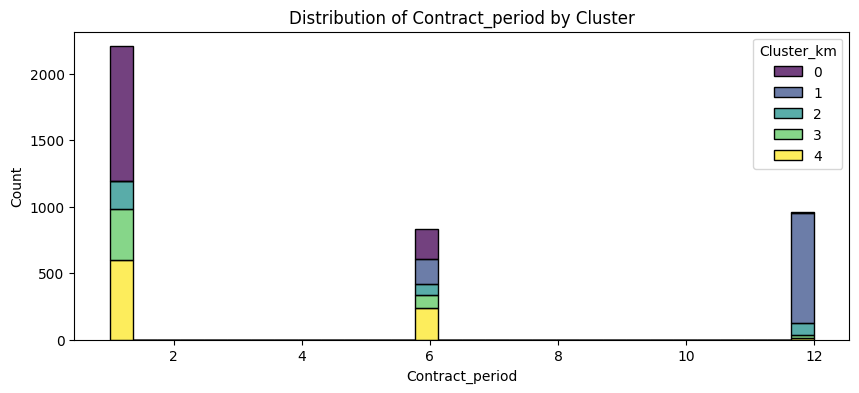

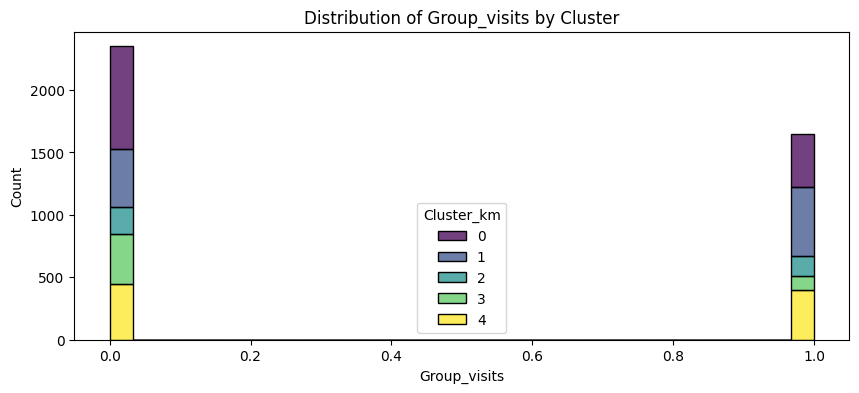

In [22]:
#Distribución de características para los Clústeres
features = ['Age', 'Avg_additional_charges_total', 'Contract_period', 'Group_visits']

for feature in features:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=gym, x=feature, hue='Cluster_km', multiple='stack', bins=30, palette='viridis')
    plt.title('Distribution of ' + feature + ' by Cluster')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

Conclusiones de los gráficos:

- Del primer gráfico podemos deducir que la mayoría de clientes se concentran entre los 25 y 32 años.
- Del segundo gráfico deducimos que la mayoria de clientes tienen gastos adicionales entre 0 y 100.
- Del 3er gráfico deducimos que la mayoría de clientes mantiene tan solo un contrato por un mes.
- Del 4to gráfico deducimos que la mayoría de clientes no participan de grupos.

In [25]:
#Calculamos la tasa de cancelación para cada clúster. 
churn_rate_by_cluster = gym.groupby('Cluster_km')['Churn'].mean()
print(churn_rate_by_cluster)

Cluster_km
0    0.516026
1    0.027586
2    0.266839
3    0.441815
4    0.073460
Name: Churn, dtype: float64


¿Difieren en términos de tasa de cancelación? ¿Qué grupos son propensos a irse y cuáles son leales?

- Clúster 0: Con una tasa de cancelación del 51.60%, este grupo es el más propenso a cancelar su suscripción.

- Clúster 1: Este es el grupo más leal, con una tasa de cancelación muy baja del 2.76%. Los usuarios de este clúster tienen una alta probabilidad de mantenerse en el gym.

- Clúster 2: Tiene una tasa de cancelación moderada del 26.68%, lo que sugiere que los usuarios en este grupo están en un riesgo intermedio de cancelar.

- Clúster 3: También tiene una alta tasa de cancelación del 44.18%, lo que indica que este grupo también está en riesgo de no continuar en el gym.

- Clúster 4: Con una tasa de cancelación del 7.35%, los usuarios en este clúster son relativamente leales, pero todavía muestran algo de riesgo de irse.


### Conclusiones y recomendaciones:

 1.0 Los clústeres 0 y 3 presentan las tasas de cancelación más altas, lo que indica que estos clientes tienen una mayor probabilidad de abandonar el gym.
 - Recomendación: Implementar campañas de retención personalizadas para estos clústeres, como ofertas especiales, planes de entrenamiento personalizados. Por ejemplo, se podría ofrecer un descuento en la renovación de la membresía, etc.

2.0 El clúster 1 muestra la tasa de cancelación más baja, lo que indica un alto nivel de lealtad por parte de este grupo de clientes.
- Se podría recompensar la lealtad de estos clientes con incentivos como recompensas, acceso exclusivo a eventos o clases, descuentos en áreas especializadas, etc.

Del análisis de datos con características adicionales se observa que la mayoría de los clientes tienen entre 25 y 32 años con gastos adicionales entre 0 y 100 unidades, estos clientes generalmente son los que mantienen un contrato mensual y no participan en actividades grupales.

- Se recomienda desarrollar campañas de marketing con los patrones demográficos visualizado en el gráfico. Se podrían ofrecer promociones para los clientes que  que contratan membresías a largo plazo, descuentos y bonos por inscripción a varios meses en el gym y por último mejorar los servicios adicionales para atraer a mas clientes.